<a href="https://colab.research.google.com/github/Tj-dev-py/Sarcasm-Detection-NLP-Project/blob/main/Sarcasm_Detection_NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sarcasm Detection with NLP

In this project, we will classify News Headlines based on whether they are sarcastic or not.

We'll start by loading in some standard libraries/dependencies for working with the data, which can be found [here](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection).

In [39]:
# import dependencies

import numpy as np

import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
# download the json dataset
!gdown --id 1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v

Downloading...
From: https://drive.google.com/uc?id=1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v
To: /content/sarcasm.json
100% 5.64M/5.64M [00:00<00:00, 55.8MB/s]


In [41]:
# set the parameters here for easy access

vocab_size = 1500
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [42]:
# reading in the json file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

In [43]:
# append the items to seperate lists
sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [44]:
# spliting into train and test sets
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [48]:
# an example
training_sentences[1], training_labels[1]

("the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 0)

In [49]:
test_sentences[1], test_labels[1]

("When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how  #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",
 4)

In [50]:
# create the tokenizer and fit it on the train sentences
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [51]:
word_index = tokenizer.word_index

In [52]:
# seperating the sentences into sequences and padding them
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type,
                                truncating=trunc_type)

In [53]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [57]:
# creating the model with a Bi-LSTM layer
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=.1,
    patience=5,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           24000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_8 (Dense)              (None, 24)                1560      
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 38,129
Trainable params: 38,129
Non-trainable params: 0
_________________________________________________________________


In [59]:
# converting the padded sequences into arrays
num_epochs = 10

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)


In [60]:
# training the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), verbose=1,
                    callbacks=[callbacks])

Epoch 1/10
625/625 [==============================] - 42s 67ms/step - loss: 0.2905 - accuracy: 0.9028 - val_loss: 0.4271 - val_accuracy: 0.8350
Epoch 2/10
625/625 [==============================] - 42s 67ms/step - loss: 0.2837 - accuracy: 0.9064 - val_loss: 0.4379 - val_accuracy: 0.8347
Epoch 3/10
625/625 [==============================] - 42s 67ms/step - loss: 0.2689 - accuracy: 0.9136 - val_loss: 0.4556 - val_accuracy: 0.8363
Epoch 4/10
625/625 [==============================] - 42s 67ms/step - loss: 0.2601 - accuracy: 0.9167 - val_loss: 0.4615 - val_accuracy: 0.8357
Epoch 5/10
625/625 [==============================] - 42s 67ms/step - loss: 0.2482 - accuracy: 0.9238 - val_loss: 0.4526 - val_accuracy: 0.8295
Epoch 6/10
625/625 [==============================] - 42s 67ms/step - loss: 0.2371 - accuracy: 0.9270 - val_loss: 0.4861 - val_accuracy: 0.8298
Epoch 7/10
625/625 [==============================] - 42s 67ms/step - loss: 0.2254 - accuracy: 0.9305 - val_loss: 0.5062 - val_accuracy:

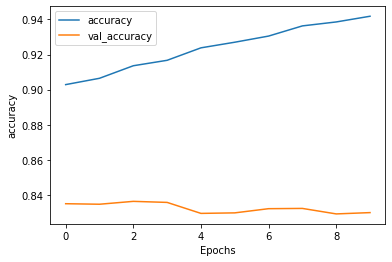

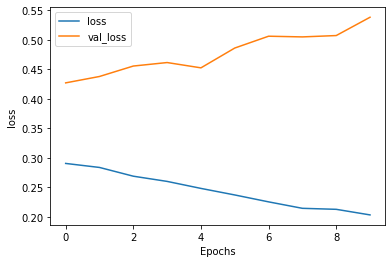

In [61]:
# plot the results of the model

import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')